# <strong>STOR 515 Final Project</strong>
Fraud Detection Using Randomized Weighted Majority Algorithm\
Group 2:\
Zenan Ji\
Xinyue Xing\
William Li\
Zhan Lin

## Library importing and data loading

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv('../data/card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


## Data Processing

In [3]:
# check for null in each column
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [4]:
# check data types of each column
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object

In [5]:
# convert the binary columns into Int type
num_cols = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
cat_cols = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']
for col in cat_cols:
  df[col] = df[col].astype('int')

In [6]:
# check the statistics of each numerical column
df[num_cols].describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
count,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182
std,65.390784,25.843093,2.799589
min,0.004874,0.000118,0.004399
25%,3.878008,0.296671,0.475673
50%,9.967760,0.998650,0.997717
75%,25.743985,3.355748,2.096370
max,10632.723672,11851.104565,267.802942


<Axes: xlabel='Fraud or Not', ylabel='Count'>

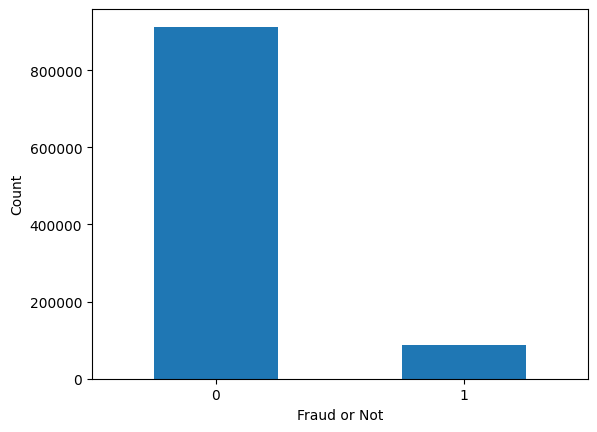

In [7]:
df['fraud'].value_counts().plot(kind='bar', ylabel='Count', rot=0, xlabel = 'Fraud or Not')

The bar chart shows that the dataset is extremely imbalanced, so we should be aware to apply techniques like upsampling or downsampling when training and testing our models

## Model (expert) Training

In [8]:
# list the continuous and discrete features
cont_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
discrete_features = list(set(cat_cols) - set(['fraud']))

non_fraud = df[df['fraud'] == 0]
is_fraud = df[df['fraud'] == 1]

# downsample the dataset to ensure balance
non_fraud_downsample = resample(non_fraud,
             replace=True,
             n_samples=len(is_fraud),
             random_state=42)
df_downsampled = pd.concat([is_fraud, non_fraud_downsample])

scaler = RobustScaler()

# turn dataset into matrices to be fed to the models
X_cont = df_downsampled[cont_features].values
X_disc = df_downsampled[discrete_features].values

X = np.concatenate((X_cont, X_disc), axis = 1)
y = df_downsampled['fraud'].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = .7)

# normalize the numerical features to fit the models
X_train[:, 0:3] = scaler.fit_transform(X_train[:, 0:3])
X_test[:, 0:3]= scaler.fit_transform(X_test[:, 0:3])

### Logistic Regression

In [9]:
# initialize the model
lr = LogisticRegressionCV()

lr.fit(X_train, y_train)

LogisticRegressionCV()

In [10]:
y_pred_probs = lr.predict_proba(X_test)[:,1]

y_lr_pred = y_pred_probs >= 0.5

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_lr_pred)))
print(classification_report(y_test, y_lr_pred, target_names =['Non fraud', 'Fraud'], digits = 4))

Accuracy: 0.94
              precision    recall  f1-score   support

   Non fraud     0.9503    0.9331    0.9416     26211
       Fraud     0.9343    0.9513    0.9427     26231

    accuracy                         0.9422     52442
   macro avg     0.9423    0.9422    0.9422     52442
weighted avg     0.9423    0.9422    0.9422     52442



### Naive Bayes

In [11]:
# initialize the model
nb = GaussianNB()

nb.fit(X_train, y_train)

GaussianNB()

In [12]:
y_pred_probs = nb.predict_proba(X_test)[:,1]

y_nb_pred = y_pred_probs >= 0.5

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_nb_pred)))
print(classification_report(y_test, y_nb_pred, target_names =['Non fraud', 'Fraud'], digits = 4))

Accuracy: 0.94
              precision    recall  f1-score   support

   Non fraud     0.9623    0.9105    0.9357     26211
       Fraud     0.9151    0.9644    0.9391     26231

    accuracy                         0.9374     52442
   macro avg     0.9387    0.9374    0.9374     52442
weighted avg     0.9387    0.9374    0.9374     52442



### Linear SVM with SGD training

In [13]:
# initialize the model
sgd = SGDClassifier(loss = 'hinge', penalty = 'l2', max_iter = 200)

sgd.fit(X_train, y_train)

SGDClassifier(max_iter=200)

In [14]:
y_sgd_pred = sgd.predict(X_test)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_sgd_pred)))
print(classification_report(y_test, y_sgd_pred, target_names =['Non fraud', 'Fraud'], digits = 4))

Accuracy: 0.94
              precision    recall  f1-score   support

   Non fraud     0.9653    0.9208    0.9425     26211
       Fraud     0.9243    0.9669    0.9451     26231

    accuracy                         0.9438     52442
   macro avg     0.9448    0.9438    0.9438     52442
weighted avg     0.9448    0.9438    0.9438     52442



### Decision Tree

In [15]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [16]:
# View performance of model
y_pred_probs = clf.predict_proba(X_test)[:,1]

y_train_pred_probs = clf.predict_proba(X_train)[:,1]

y_clf_pred = y_pred_probs >= 0.5

print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_clf_pred)))
print(classification_report(y_test, y_clf_pred, target_names =['Non default', 'Default'], digits = 4))

Accuracy: 0.9968
              precision    recall  f1-score   support

 Non default     0.9937    1.0000    0.9968     26211
     Default     1.0000    0.9936    0.9968     26231

    accuracy                         0.9968     52442
   macro avg     0.9968    0.9968    0.9968     52442
weighted avg     0.9968    0.9968    0.9968     52442



### K-Nearest Neighbors

In [17]:
knn = KNeighborsClassifier(n_neighbors = 4)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [18]:
y_pred_probs = knn.predict_proba(X_test)[:,1]

y_knn_pred = y_pred_probs >= 0.5

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_knn_pred)))
print(classification_report(y_test, y_knn_pred, target_names =['Non fraud', 'Fraud'], digits = 4))

Accuracy: 0.99
              precision    recall  f1-score   support

   Non fraud     0.9984    0.9829    0.9906     26211
       Fraud     0.9831    0.9985    0.9908     26231

    accuracy                         0.9907     52442
   macro avg     0.9908    0.9907    0.9907     52442
weighted avg     0.9908    0.9907    0.9907     52442



### "Dumb" Experts

In [19]:
# constantly predicting True/False
class DumbGuesser:
    def __init__(self, guess = False):
        self.guess = guess
    def predict(self):
        return self.guess


class RandomGuesser:
    def __init__(self):
        self.rand = np.random
    def predict(self):
        return self.rand.rand() >= 0.5

In [20]:
dbgt = DumbGuesser(True)
dbgt.predict()
dbgf = DumbGuesser(True)
dbgf.predict()
rdg = RandomGuesser()


## Baseline Method:
### WMA and RWM directly predicting y_test

In [21]:
# numbers of experts, rounds, mistakes
N = 8
T = len(y_test)
wma_mistakes = 0
rwm_mistakes = []
expert_mistakes = [ 0 for i in range(N) ]

# lists for storing expert predictions and our predictions
yhat = []
expert_y = [ [] for i in range(N) ]

# picking a practical value for epsilon to be used in both algorithms
epsilon = (np.log(N)/T)**(1/2)

# reading in expert predictions and actual y
expert_y[0] = lr.predict(X_test)
expert_y[1] = nb.predict(X_test)
expert_y[2] = sgd.predict(X_test)
expert_y[3] = clf.predict(X_test)
expert_y[4] = knn.predict(X_test)
for i in range(len(X_test)):
	expert_y[5].append(int(dbgt.predict()))
	expert_y[6].append(int(dbgt.predict()))
	expert_y[7].append(int(rdg.predict()))


In [22]:
# WMA

# initializing weights
w = [ 1 for i in range(N) ]

for t in range(T):
	
	W = sum(w)
	wf = 0
	for i in range(N):
		wf += w[i]*expert_y[i][t]
	if wf/W >=0.5:
		yhat.append(1)
	else:
		yhat.append(0)
	# checking if the prediction is right
	if yhat[t] != y_test[t]:
		wma_mistakes = wma_mistakes + 1
	# updating expert weights and count mistakes
	for i in range(N):
		if expert_y[i][t] != y_test[t]:
			w[i] = w[i]*(1-epsilon)
			expert_mistakes[i] = expert_mistakes[i] + 1

print(w)
print(wma_mistakes)
wma_accuracy = (T-wma_mistakes)/T
print(wma_accuracy)

[4.808540950768944e-09, 9.97486192985751e-10, 8.33084507490513e-09, 0.3460261473974455, 0.0640650698520032, 1.238114808371126e-72, 1.238114808371126e-72, 1.0843001869388327e-72]
223
0.9957476831547233


In [23]:
# RWM

# number of times to run it
K=100

for k in range(K):
	# reset weights, add mistake counter before starting
	w = [ 1 for i in range(N) ]
	rwm_mistakes.append(0)

	# moving through rounds, making predictions and updating weights as necessary
	for t in range(T):
		# calculating collective weight of all experts
		W = sum(w)
		# setting up probability distribution for picking expert
		expert_probs = []
		for i in range(N):
			expert_probs.append(w[i]/W)
		# randomly choosing an expert's prediction to use as your own
		chosen_expert = np.random.choice(N, 1, p=expert_probs)
		# checking if that expert (and thus your prediction) was right
		if expert_y[chosen_expert[0]][t] != y_test[t]:
			rwm_mistakes[k] = rwm_mistakes[k] + 1
		# updating expert weights
		for i in range(N):
			if expert_y[i][t] != y_test[t]:
				w[i] = w[i]*(1-epsilon)

print(np.average(rwm_mistakes))
rwm_accuracy = (T-np.average(rwm_mistakes))/T
print(rwm_accuracy)

473.57
0.9909696426528355


### The accuracies of previous WMA and RWM aren't higher compared with the accuracy of Decision Tree model.
### In order to improve the performance, we try:
#### (1) implementing WMA on training dataset to get the optimal weights for different experts, and determining y_test accordingly
#### (2) implementing WMA on training dataset with only Decision Tree expert and KNN expert and determining y_test according to the weights
#### (3) implementing RWM without dumb experts
#### (4) implementing RWM with only Decision Tree expert and KNN expert(the best two models)
#### (5) implementing RWM with all experts in baseline model and 13 more random guess experts

## (1)

In [24]:

eps = (np.log(N)/len(y_train))**(1/2)

yhat = []
expert_y_train = [ [] for i in range(N) ]

expert_y_train[0] = lr.predict(X_train)
expert_y_train[1] = nb.predict(X_train)
expert_y_train[2] = sgd.predict(X_train)
expert_y_train[3] = clf.predict(X_train)
expert_y_train[4] = knn.predict(X_train)
for i in range(len(X_train)):
	expert_y_train[5].append(int(dbgt.predict()))
	expert_y_train[6].append(int(dbgt.predict()))
	expert_y_train[7].append(int(rdg.predict()))

# initializing weights
w = [ 1 for i in range(N) ]

# moving through rounds, making predictions and updating weights as necessary
for t in range(len(y_train)):
	# calculating collective weight of all experts
	W = sum(w)
	wf = 0
	for i in range(N):
		wf += w[i]*expert_y_train[i][t]
	if wf/W >=0.5:
		yhat.append(1)
	else:
		yhat.append(0)
	# updating expert weights and count mistakes
	for i in range(N):
		if expert_y_train[i][t] != y_train[t]:
			w[i] = w[i]*(1-eps)

print(w)

[1.3535892513734212e-13, 1.4247721465604506e-14, 5.247178115017782e-13, 1, 0.1321081703847627, 1.6605920670970044e-110, 1.6605920670970044e-110, 3.5364605182093896e-110]


In [25]:
y_pred = []
for i in range(N):
    w[i] = w[i]/W

print(sum(w))
print(w)

for t in range(len(y_test)):
    wf = 0
    for i in range(N):
        wf += w[i]*expert_y[i][t]
    if wf >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

print(accuracy_score(y_pred,y_test))


1.0
[1.1956359708212148e-13, 1.2585123787909537e-14, 4.634873461986703e-13, 0.8833078200111748, 0.11669217998822957, 1.4668139587153056e-110, 1.4668139587153056e-110, 3.123783230895126e-110]
0.9967964608519889


## (2)

In [26]:
# initializing weights
w = [ 1 for i in range(2)]
eps2 = (np.log(2)/T)**(1/2)
best_experts = [ [] for i in range(2) ]
best_experts[0] = expert_y_train[3]
best_experts[1] = expert_y_train[4]
W=0
# moving through rounds, making predictions and updating weights as necessary
for t in range(T):
	W = sum(w)
	wf = 0
	for i in range(2):
		wf += w[i]*best_experts[i][t]
	if wf/W >=0.5:
		yhat.append(1)
	else:
		yhat.append(0)
		
	for i in range(2):
		if best_experts[i][t] != y_train[t]:
			w[i] = w[i]*(1-eps2)
sum = sum(w)
w[0] = w[0]/sum
w[1] = w[1]/sum
print(w)
y_pred_new=[]
for t in range(len(y_test)):
    wf = 0
    wf += w[0]*expert_y[3][t]
    wf += w[1]*expert_y[4][t]
    if wf >= 0.5:
        y_pred_new.append(1)
    else:
        y_pred_new.append(0)


print(accuracy_score(y_pred_new,y_test))

[0.6808275626379657, 0.3191724373620342]
0.9967964608519889


## (3)

In [27]:
# Only taking the machine learning models as experts
rwm_mistakes_2 = []
for k in range(K):
	w = [ 1 for i in range(5) ]
	rwm_mistakes_2.append(0)
	for t in range(T):
		W = np.sum(w)
		expert_probs = []
		for i in range(5):
			expert_probs.append(w[i]/W)
		chosen_expert = np.random.choice(5, 1, p=expert_probs)
		if expert_y[chosen_expert[0]][t] != y_test[t]:
			rwm_mistakes_2[k] = rwm_mistakes_2[k] + 1
		for i in range(5):
			if expert_y[i][t] != y_test[t]:
				w[i] = w[i]*(1-epsilon)
print(np.average(rwm_mistakes_2))
rwm_accuracy_2 = (T-np.average(rwm_mistakes_2))/T
print(rwm_accuracy_2)	

397.93
0.9924119980168568


## (4)

In [28]:
rwm_mistakes_3 = []
best_experts = [ [] for i in range(2) ]
best_experts[0] = expert_y[3]
best_experts[1] = expert_y[4]
for k in range(K):
	w = [ 1 for i in range(2) ]
	rwm_mistakes_3.append(0)

	for t in range(T):
		W = np.sum(w)
		expert_probs = []
		for i in range(2):
			expert_probs.append(w[i]/W)
		chosen_expert = np.random.choice(2, 1, p=expert_probs)
		if best_experts[chosen_expert[0]][t] != y_test[t]:
			rwm_mistakes_3[k] = rwm_mistakes_3[k] + 1
		for i in range(2):
			if best_experts[i][t] != y_test[t]:
				w[i] = w[i]*(1-epsilon)
print(np.average(rwm_mistakes_3))
rwm_accuracy_3 = (T-np.average(rwm_mistakes_3))/T
print(rwm_accuracy_3)			

250.89
0.9952158575187827
